In [686]:
import pandas as pd
from pathlib import Path
from loguru import logger
from peppcbench.utils import load_job_info, get_ids_from_name
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from typing import List
from math import comb

In [687]:
job_list_path = Path("../job_list.csv")
data_dir = Path("../pepdb")

In [688]:
def build_task_args_list(data_dir: Path, model_name: str):
    args_list = []
    for job_dir in data_dir.iterdir():
        if not job_dir.is_dir():
            continue

        job_info = load_job_info(job_dir)
        job_name = job_info["job_name"]
        infer_done_flag = job_dir / model_name / "infer.done"
        if not infer_done_flag.exists():
            logger.warning(f"{job_name} was not finished, skipping")
            continue

        for sample_dir in (job_dir / "af3" / job_name.lower()).glob("seed-*_sample-*"):
            if not sample_dir.is_dir():
                continue
            seed_id, sample_id = get_ids_from_name(sample_dir.name)
            args_list.append(
                {
                    "job_id": job_dir.name,
                    "model_name": model_name,
                    "seed_id": seed_id,
                    "sample_id": sample_id,
                }
            )
    return args_list

args_list = build_task_args_list(data_dir, "af3")
df = pd.DataFrame(args_list)
df.head()

,job_id,model_name,seed_id,sample_id
0,8c5l_C,af3,1,0
1,8c5l_C,af3,1,1
2,8c5l_C,af3,1,2
3,8c5l_C,af3,1,3
4,8c5l_C,af3,1,4


In [689]:
id_cols = ["job_id", "seed_id", "sample_id", "model_name"]

In [690]:
dockq_df = pd.read_csv("../results/af3_dockq.csv")
df = pd.merge(df, dockq_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

dockq_relax_df = pd.read_csv("../results/af3_dockq_relaxed.csv")
dockq_relax_df.rename(columns={
    "DockQ": "DockQ_relax",
    "F1": "F1_relax",
    "iRMSD": "iRMSD_relax",
    "LRMSD": "LRMSD_relax",
    "fnat": "fnat_relax",
    }, inplace=True)
df = pd.merge(df, dockq_relax_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

confidence_df = pd.read_csv("../results/af3_confidence.csv")
df = pd.merge(df, confidence_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:20.750 | INFO     | __main__:<module>:18 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:20.751 | INFO     | __main__:<module>:19 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score]
Index: []

[0 rows x 25 columns]


In [691]:
deltag_df = pd.read_csv("../results/af3_deltag.csv")
deltag_df = deltag_df[id_cols + ["dG_cross"]]
df = pd.merge(df, deltag_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:20.848 | INFO     | __main__:<module>:6 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:20.850 | INFO     | __main__:<module>:7 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_cross]
Index: []

[0 rows x 26 columns]


In [692]:
deltag_relax_df = pd.read_csv("../results/af3_deltag_relax.csv")
deltag_relax_df = deltag_relax_df[id_cols + ["dG_cross"]]
rename_dict = {
    "dG_cross": "dG_cross_relax",
}
deltag_relax_df.rename(columns=rename_dict, inplace=True)
df = pd.merge(
    df, deltag_relax_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left"
)

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:20.936 | INFO     | __main__:<module>:12 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:20.938 | INFO     | __main__:<module>:13 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_cross, dG_cross_relax]
Index: []

[0 rows x 27 columns]


In [693]:
iASA_df = pd.read_csv("../results/af3_iASA.csv")
df = pd.merge(df, iASA_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:21.034 | INFO     | __main__:<module>:5 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:21.036 | INFO     | __main__:<module>:6 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_cross, dG_cross_relax, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex]
Index: []

[0 rows x 32 columns]


In [694]:
iASA_df_relax = pd.read_csv("../results/af3_iASA_relaxed.csv")
iASA_df_relax.rename(columns={
    "iASA": "iASA_relax",
    "iASA%": "iASA%_relax",
    "sasa_peptide": "sasa_peptide_relax",
    "sasa_protein": "sasa_protein_relax",
    "sasa_complex": "sasa_complex_relax",
    }, inplace=True)
df = pd.merge(df, iASA_df_relax, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:21.132 | INFO     | __main__:<module>:12 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:21.133 | INFO     | __main__:<module>:13 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_cross, dG_cross_relax, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex, iASA_relax, iASA%_relax, sasa_peptide_relax, sasa_protein_relax, sasa_complex_relax]
Index: []

[0 rows x 37 columns]


In [695]:
summary_df = pd.read_csv("../results/job_summary.csv")
summary_df.rename(columns={"job_name": "job_id"}, inplace=True)
df = pd.merge(df, summary_df, on=["job_id"], how="left")

difficulty_df = pd.read_csv("../results/af3_difficulty.csv")
df = pd.merge(df, difficulty_df, on=["job_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:21.233 | INFO     | __main__:<module>:9 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:21.234 | INFO     | __main__:<module>:10 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_cross, dG_cross_relax, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex, iASA_relax, iASA%_relax, sasa_peptide_relax, sasa_protein_relax, sasa_complex_relax, pdb_id, peptide_chains, protein_chains, peptide_chain_len, peptide_chain_has_ncaa, msa_status_af3, infer_status_af3, helical, extended, ppii, difficulty]
Index: []

[0 rows x 48 columns]


In [696]:
deepppiscore_df = pd.read_csv("../results/af3_deepppiscore.csv")
deepppiscore_df["model_name"] = "af3"
deepppiscore_df["job_id"] = deepppiscore_df["pdbid"].apply(lambda x: "_".join(x.split("_")[:2]))
deepppiscore_df["seed_id"] = deepppiscore_df["pdbid"].apply(lambda x: x.split("_")[2]).astype(int)
deepppiscore_df["sample_id"] = deepppiscore_df["pdbid"].apply(lambda x: x.split("_")[3]).astype(int)
deepppiscore_df["min-min score"] = deepppiscore_df["min-min score"].fillna(deepppiscore_df["min-min score"].mean())
deepppiscore_df = deepppiscore_df[id_cols + ["min-min score"]]
df = pd.merge(df, deepppiscore_df, on=["job_id", "seed_id", "sample_id", "model_name"], how="left")

missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-08 12:37:21.425 | INFO     | __main__:<module>:11 - Below are examples of rows with missing values after merging:
2025-04-08 12:37:21.427 | INFO     | __main__:<module>:12 - Empty DataFrame
Columns: [job_id, model_name, seed_id, sample_id, DockQ, F1, iRMSD, LRMSD, fnat, clashes_x, DockQ_relax, F1_relax, iRMSD_relax, LRMSD_relax, fnat_relax, clashes_y, original_iptm, original_ptm, actifptm, iptm, ptm, confidence_score, original_confidence_score, ranking_score, original_ranking_score, dG_cross, dG_cross_relax, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex, iASA_relax, iASA%_relax, sasa_peptide_relax, sasa_protein_relax, sasa_complex_relax, pdb_id, peptide_chains, protein_chains, peptide_chain_len, peptide_chain_has_ncaa, msa_status_af3, infer_status_af3, helical, extended, ppii, difficulty, min-min score]
Index: []

[0 rows x 49 columns]


In [697]:
dockq_mean_total = df["DockQ"].mean()
dockq_relax_mean_total = df["DockQ_relax"].mean()
increase = dockq_relax_mean_total - dockq_mean_total
print(f"totoal improve (mean): {increase} ({increase / dockq_mean_total * 100} %)")

max_sample_df = df.loc[df.groupby(['job_id', 'model_name'])['original_confidence_score'].idxmax()]
max_sample_df_relax = df.loc[df.groupby(['job_id', 'model_name'])['original_confidence_score'].idxmax()]
print(len(max_sample_df), len(max_sample_df_relax))

dockq_mean_best = max_sample_df["DockQ"].mean()
dockq_mean_best_relax = max_sample_df_relax["DockQ_relax"].mean()
increase_relax = dockq_mean_best_relax - dockq_mean_best
print(f"totoal improve (best): {increase_relax} ({increase_relax / dockq_mean_best * 100} %)")

totoal improve (mean): 0.001191567062965193 (0.1872113560777312 %)
261 261
totoal improve (best): 0.0014392686579478564 (0.21617174121232618 %)


In [698]:
# 选出每个 job_id 下 confidence_score 最大的行（即“最佳模型”）
best_df = df.loc[df.groupby(['job_id'])['original_confidence_score'].idxmax()]

# 计算每个 job 的提升
best_df['dockq_diff'] = best_df['DockQ_relax'] - best_df['DockQ']

# 哪些提升了？哪些降低了？
improved = best_df[best_df['dockq_diff'] > 0]
decreased = best_df[best_df['dockq_diff'] < 0]

print(f"🌟 DockQ 提升的个数: {len(improved)}")
print(f"🔻 DockQ 降低的个数: {len(decreased)}")

# 可选：展示前几项
print("\n提升最多的前10个 job_id:")
print(improved.sort_values('dockq_diff', ascending=False)[['job_id', 'DockQ', 'DockQ_relax', 'dockq_diff', 'difficulty', 'fnat', 'LRMSD', 'peptide_chain_len']].head(10))
print(improved["dockq_diff"].mean())

print("\n降低最多的前10个 job_id:")
print(decreased.sort_values('dockq_diff')[['job_id', 'DockQ', 'DockQ_relax', 'dockq_diff', 'difficulty', 'fnat_relax', 'LRMSD_relax', 'peptide_chain_len']].head(10))
print(decreased["dockq_diff"].mean())

🌟 DockQ 提升的个数: 117
🔻 DockQ 降低的个数: 144

提升最多的前10个 job_id:
       job_id     DockQ  DockQ_relax  dockq_diff difficulty      fnat  \
29789  8t0p_C  0.738938     0.784893    0.045955       Easy  0.464286   
13980  8p9r_C  0.826768     0.867896    0.041128       Easy  0.708333   
11602  8ofg_C  0.232827     0.273766    0.040940       Easy  0.375000   
49849  8kcv_C  0.807849     0.843361    0.035512       Easy  0.676471   
42718  8wee_B  0.877465     0.911523    0.034058       Easy  0.750000   
31585  8t5q_G  0.958267     0.989972    0.031705       Easy  0.900000   
16338  8pxx_B  0.553157     0.583255    0.030098     Medium  0.772727   
9606   8jgg_L  0.371791     0.399093    0.027302       Easy  0.400000   
14513  8pef_B  0.231501     0.255654    0.024153       Easy  0.185185   
48481  9fj4_B  0.768534     0.792525    0.023991       Easy  0.690476   

           LRMSD  peptide_chain_len  
29789   1.949368                 18  
13980   1.235393                 23  
11602  13.760450         

In [699]:
df["dG_cross"]

0        160.7146
1         49.4515
2         16.6315
3         59.4020
4         76.0320
           ...   
52195    -39.1559
52196    -24.3757
52197    -44.9911
52198     -1.7005
52199    -11.6583
Name: dG_cross, Length: 52200, dtype: float64

In [700]:
def rerank_score(
    df: pd.DataFrame, metric: str, ascending: bool = False
) -> pd.DataFrame:
    df = df.copy()
    rank_methods = "first"
    df["global_rank_{}".format(metric)] = (
        df.groupby(["job_id"])[metric]
        .rank(
            method=rank_methods, ascending=ascending
        )  # Use 'first' for deterministic tie-breaking
        .astype(int)
    )
    return df

In [701]:
# df["dG_cross_iASA"] = df["dG_cross"] / df["iASA%"]
# df["dG_cross_iASA_relax"] = df["dG_cross_relax"] / df["iASA%_relax"]

In [702]:
df = rerank_score(df, metric="original_ranking_score", ascending=False)
df = rerank_score(df, metric="dG_cross", ascending=True)
df = rerank_score(df, metric="dG_cross_relax", ascending=True)
df = rerank_score(df, metric="actifptm", ascending=False)
df = rerank_score(df, metric="original_iptm", ascending=False)

In [703]:
def get_capri(fnat: float, lrmsd: float, irmsd: float) -> float:
    if (fnat >= 0.8 and fnat <= 1) and (lrmsd < 1 or irmsd < 0.5):
        return 3
    elif (fnat >= 0.5 and fnat <= 0.8) and (lrmsd < 2 or irmsd < 1) or (fnat >= 0.8 and fnat <= 1):
        return 2
    elif (fnat >= 0.2 and fnat <= 0.5) and (lrmsd < 4 or irmsd < 2) or (fnat >= 0.5 and fnat <= 1) and (lrmsd > 2 and irmsd > 1):
        return 1
    else:
        return 0

In [704]:
df["capri"] = df.apply(lambda x: get_capri(x["fnat_relax"], x["LRMSD_relax"], x["iRMSD_relax"]), axis=1)

In [705]:
def get_success(df, mode="high"):
    _df = df.copy()
    if mode == "high":
        _df["success"] = _df["capri"] == 3
    elif mode == "medium":
        _df["success"] = _df["capri"] >= 2
    elif mode == "acceptable":
        _df["success"] = _df["capri"] >= 1
    elif mode == "inacceptable":
        _df["success"] = _df["capri"] == 0
    else:
        raise ValueError(f"Invalid mode: {mode}")
    return _df["success"]

In [718]:
def cal_top1_success(df: pd.DataFrame, rank_col: str) -> float:
    n_total_jobs = len(df["job_id"].unique())
    n_success = 0
    for job_id, group in df.groupby("job_id"):
        sub = group[group["success"] == True]
        top1 = sub[sub[rank_col].astype(int) == 1]
        if not top1.empty:
            n_success += 1
    return n_success / n_total_jobs if n_total_jobs > 0 else 0


def cal_intersection_success(df: pd.DataFrame, rank_colA: str, metric_colB: str) -> float:
    n_total_jobs = len(df["job_id"].unique())
    n_success = 0
    for job_id, group in df.groupby("job_id"):
        topA = group[group[rank_colA] <= 100].copy()
        topA["rank_B"] = topA[metric_colB].rank(method="first", ascending=False).astype(int)
        top1 = topA[topA["rank_B"] == 1]
        successful = top1[top1["success"] == True]
        if not successful.empty:
            n_success += 1
    return n_success / n_total_jobs if n_total_jobs > 0 else 0

def cal_uplimit_success(df: pd.DataFrame) -> float:
    n_total_jobs = len(df["job_id"].unique())
    n_success = 0
    for job_id, group in df.groupby("job_id"):
        sub = group[group["success"] == True]
        if not sub.empty:
            n_success += 1
    return n_success / n_total_jobs if n_total_jobs > 0 else 0


def calculate_expected_success(df: pd.DataFrame, top_n: int = 1) -> float:
    job_stats = (
        df.groupby("job_id")["success"]
        .agg(["sum", "count"])
        .rename(columns={"sum": "k", "count": "n"})
    )
    probs = []
    for _, row in job_stats.iterrows():
        k, n = int(row["k"]), int(row["n"])
        if top_n > n:
            continue
        if k == 0:
            probs.append(0.0)
        else:
            p_all_false = comb(n - k, top_n) / comb(n, top_n) if top_n <= n - k else 0
            probs.append(1 - p_all_false)
    return np.mean(probs)


def plot_top1_success_by_threshold(df: pd.DataFrame):

    methods = {
        "Expected": "Expected",
        "Score": "global_rank_original_ranking_score",
        "Binding Energy": "global_rank_dG_cross",
        "Binding Energy Relaxed": "global_rank_dG_cross_relax",
        "ipTM": "global_rank_original_iptm",
        "actifpTM": "global_rank_actifptm",
        # "Intersection": "Intersection",
        "Uplimit": "Uplimit",
    }

    thresholds = ["acceptable", "medium", "high"]
    rename_dict = {
        "acceptable": "Acceptable",
        "medium": "Medium",
        "high": "High",
    }
    records = []
    for mode in thresholds:
        df["success"] = get_success(df, mode=mode)
        for name, col in methods.items():
            if col == "Expected":
                success_rate = calculate_expected_success(df, top_n=1)
            elif col == "Uplimit":
                success_rate = cal_uplimit_success(df)
            elif col == "Intersection":
                success_rate = cal_intersection_success(
                    df,
                    rank_colA="global_rank_dG_cross_relax",
                    metric_colB="original_ranking_score",
                )
            else:
                success_rate = cal_top1_success(df, col)
            records.append(
                {
                    "Threshold": rename_dict[mode],
                    "Metric": name,
                    "Top-1 Success Rate": success_rate,
                }
            )

    plot_data = pd.DataFrame(records)

    # 设置颜色：Expected 为灰色，其余为 Set3
    non_expected_metrics = [metric for metric in methods if metric != "Expected"]
    set3_colors = sns.color_palette("Set3", len(non_expected_metrics))

    color_mapping = {
        "Expected": "lightgray",
        "Score": set3_colors[0],
        "Binding Energy": set3_colors[1],
        "Binding Energy Relaxed": set3_colors[3],
        "ipTM": set3_colors[4],
        "actifpTM": set3_colors[5],
        "Uplimit": set3_colors[2],
    }

    plt.figure(figsize=(8, 4), dpi=600)
    ax = sns.barplot(
        data=plot_data,
        x="Threshold",
        y="Top-1 Success Rate",
        hue="Metric",
        palette=color_mapping,
        edgecolor="black",
        width=0.8,
        alpha=1,
    )

    # 添加数值标签，减小字体大小
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.01,
                    f"{height:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=8.5,  # ✅ 减小字体
                )

    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.ylabel("Top-1 Success Rate")

    # ✅ 减小 legend 字体大小
    legend = plt.legend(
        loc="best",
        fontsize=8,
    )
    plt.xlabel("")

    plt.tight_layout()
    plt.show()

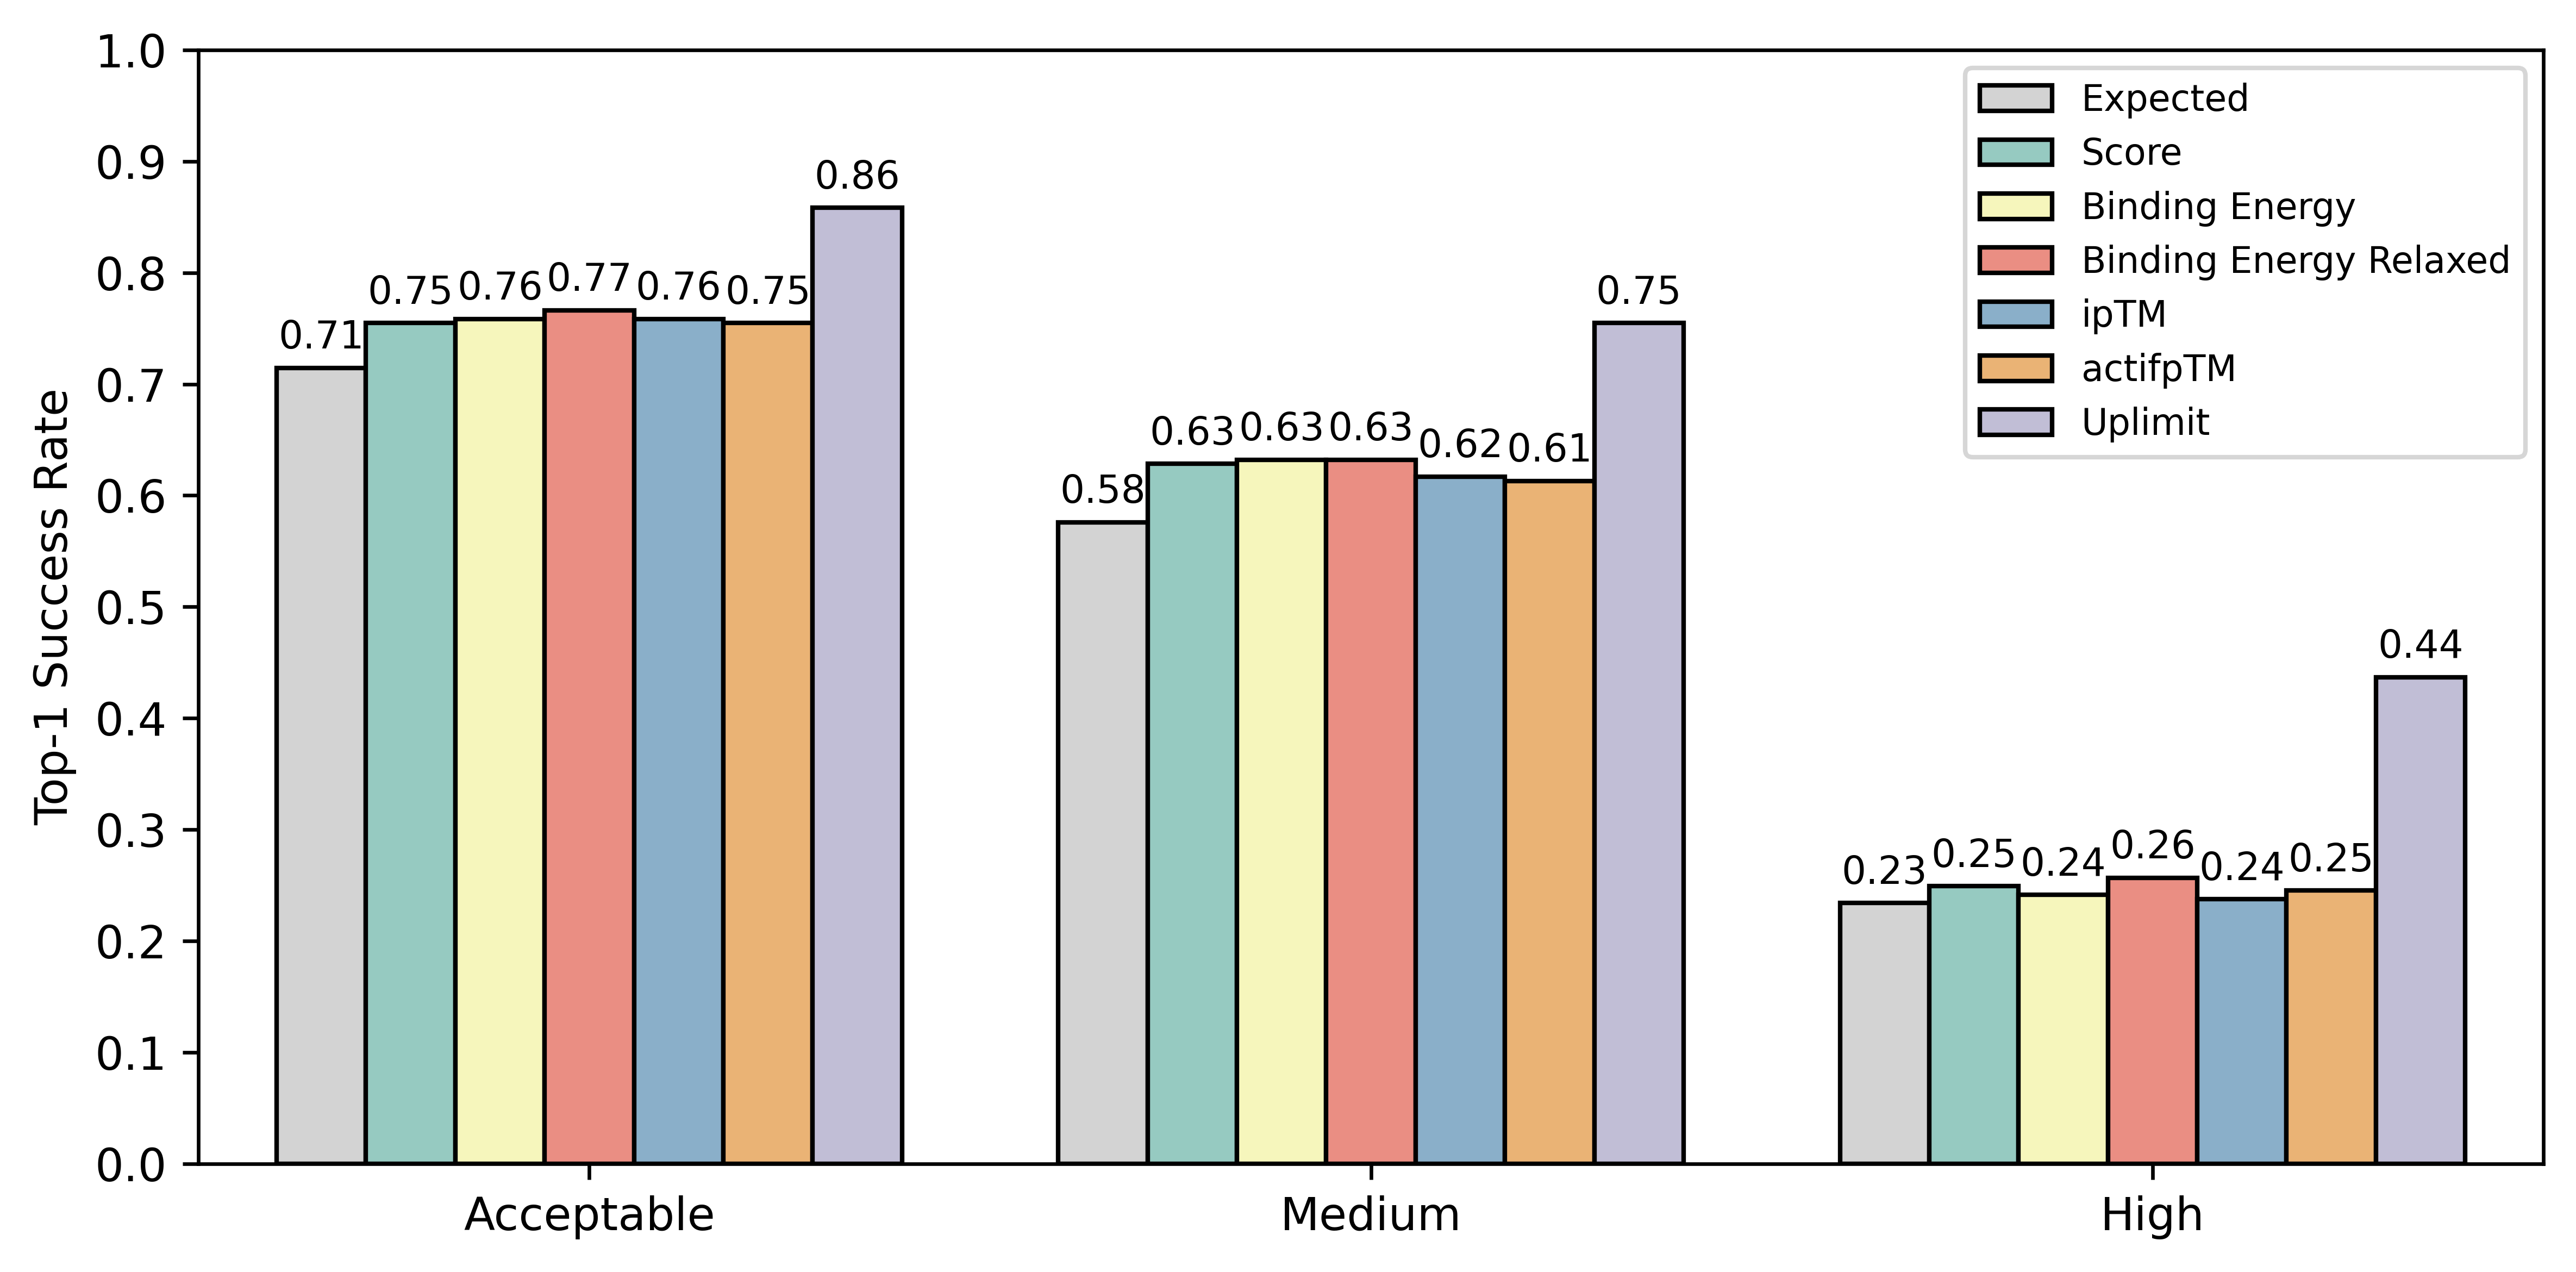

In [719]:
plot_top1_success_by_threshold(df)